In [90]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 11

In [91]:
# Load data and check coverage
conn = sqlite3.connect('../output/literary_works.db')

# Coverage statistics
total_items = pd.read_sql('SELECT COUNT(DISTINCT item_id) as cnt FROM literary_works', conn)['cnt'].values[0]
items_with_year = pd.read_sql('SELECT COUNT(DISTINCT item_id) as cnt FROM literary_works WHERE year IS NOT NULL', conn)['cnt'].values[0]
items_with_region = pd.read_sql('''
    SELECT COUNT(DISTINCT lw.item_id) as cnt 
    FROM literary_works lw
    LEFT JOIN countries c ON lw.modern_country = c.modern_country
    WHERE c.macro_region IS NOT NULL
''', conn)['cnt'].values[0]
items_with_both = pd.read_sql('''
    SELECT COUNT(DISTINCT lw.item_id) as cnt 
    FROM literary_works lw
    LEFT JOIN countries c ON lw.modern_country = c.modern_country
    WHERE lw.year IS NOT NULL AND c.macro_region IS NOT NULL
''', conn)['cnt'].values[0]

print("=" * 50)
print("DATA COVERAGE")
print("=" * 50)
print(f"Total unique items in database: {total_items:,}")
print(f"Items with year:                {items_with_year:,} ({items_with_year/total_items*100:.1f}%)")
print(f"Items with region:              {items_with_region:,} ({items_with_region/total_items*100:.1f}%)")
print(f"Items with BOTH year AND region: {items_with_both:,} ({items_with_both/total_items*100:.1f}%)")
print("=" * 50)

# Query with deduplication: one row per unique item_id
# For works with multiple years, we keep the earliest year (MIN)
# For works with multiple regions, we keep all (but deduplicate per item_id + region)
query = """
WITH deduplicated AS (
    SELECT 
        lw.item_id,
        lw.itemLabel,
        lw.instanceLabel,
        lw.countryLabel,
        lw.languageLabel,
        lw.authorLabel,
        MIN(lw.year) as year,
        c.macro_region,
        c.region
    FROM literary_works lw
    LEFT JOIN countries c ON lw.modern_country = c.modern_country
    LEFT JOIN instances i ON lw.instanceLabel = i.label
    WHERE lw.year IS NOT NULL 
      AND lw.year < 1900
      AND (i.excluded = 0 OR i.excluded IS NULL)
    GROUP BY lw.item_id, c.macro_region, c.region
)
SELECT * FROM deduplicated
WHERE macro_region IS NOT NULL
"""

df = pd.read_sql(query, conn)
conn.close()

print(f"\nAnalysis subset (year < 1900, non-excluded types):")
print(f"Total unique literary works: {df['item_id'].nunique():,} ({df['item_id'].nunique()/total_items*100:.1f}% of all items)")
print(f"Date range: {df['year'].min()} - {df['year'].max()}")
print(f"Unique macro regions: {df['macro_region'].nunique()}")
print(f"Unique regions: {df['region'].nunique()}")
print(f"Unique instance types: {df['instanceLabel'].nunique()}")

DATA COVERAGE
Total unique items in database: 1,347,347
Items with year:                362,033 (26.9%)
Items with region:              708,538 (52.6%)
Items with BOTH year AND region: 265,875 (19.7%)

Analysis subset (year < 1900, non-excluded types):
Total unique literary works: 41,568 (3.1% of all items)
Date range: -2999 - 1899
Unique macro regions: 9
Unique regions: 26
Unique instance types: 546


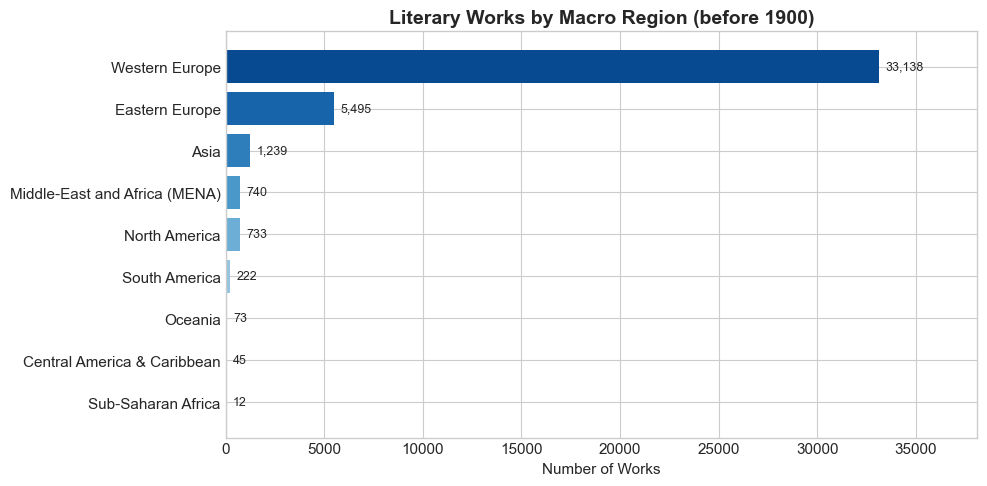

In [92]:
# Overview: Works by macro region (counting unique item_ids per macro region)
macro_region_counts = df.groupby('macro_region')['item_id'].nunique().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette('Blues_r', len(macro_region_counts))
bars = ax.barh(macro_region_counts.index[::-1], macro_region_counts.values[::-1], color=colors[::-1])
ax.set_xlabel('Number of Works')
ax.set_title('Literary Works by Macro Region (before 1900)', fontsize=14, fontweight='bold')
for bar, val in zip(bars, macro_region_counts.values[::-1]):
    ax.text(val + macro_region_counts.max()*0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:,}', va='center', fontsize=9)
ax.set_xlim(0, macro_region_counts.max() * 1.15)
plt.tight_layout()
plt.show()

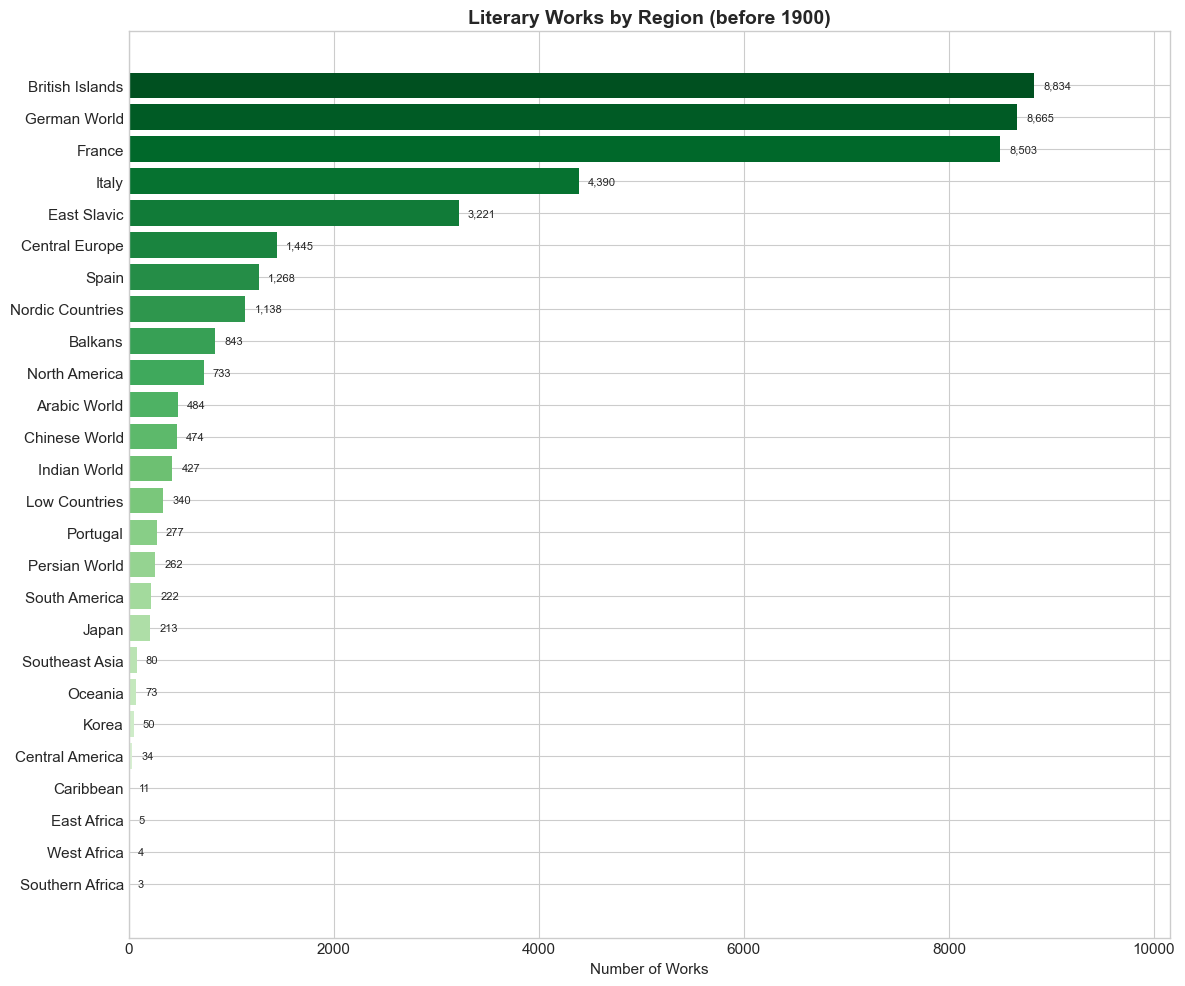

In [93]:
# Overview: Works by detailed region (counting unique item_ids per region)
region_counts = df.groupby('region')['item_id'].nunique().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 10))
colors = sns.color_palette('Greens_r', len(region_counts))
bars = ax.barh(region_counts.index[::-1], region_counts.values[::-1], color=colors[::-1])
ax.set_xlabel('Number of Works')
ax.set_title('Literary Works by Region (before 1900)', fontsize=14, fontweight='bold')
for bar, val in zip(bars, region_counts.values[::-1]):
    ax.text(val + region_counts.max()*0.01, bar.get_y() + bar.get_height()/2, 
            f'{val:,}', va='center', fontsize=8)
ax.set_xlim(0, region_counts.max() * 1.15)
plt.tight_layout()
plt.show()

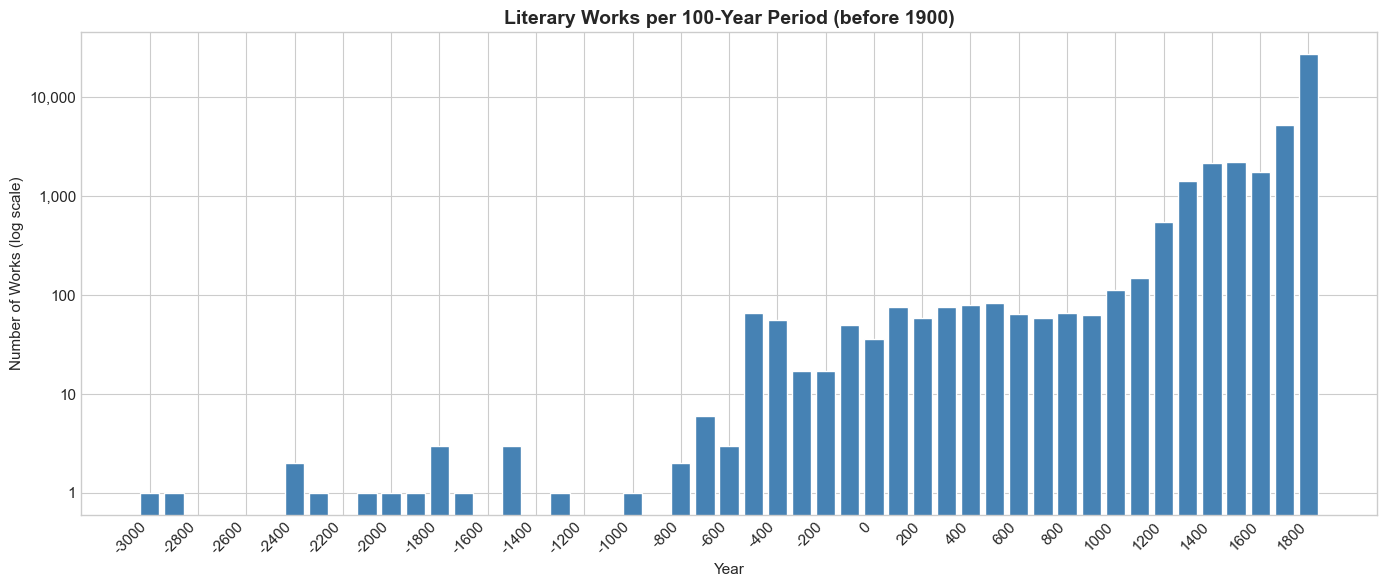

In [94]:
# Timeline: Works count per 100-year periods (log scale, counting unique item_ids)
df['century'] = (df['year'] // 100) * 100

counts_100y = df.groupby('century')['item_id'].nunique()

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(counts_100y.index, counts_100y.values, width=80, color='steelblue', edgecolor='white')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Works (log scale)')
ax.set_title('Literary Works per 100-Year Period (before 1900)', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

min_year = (counts_100y.index.min() // 100) * 100
max_year = (counts_100y.index.max() // 100 + 1) * 100
ax.set_xticks(range(min_year, max_year + 1, 200))
ax.set_xticklabels([str(y) for y in range(min_year, max_year + 1, 200)], rotation=45, ha='right')

plt.tight_layout()
plt.show()

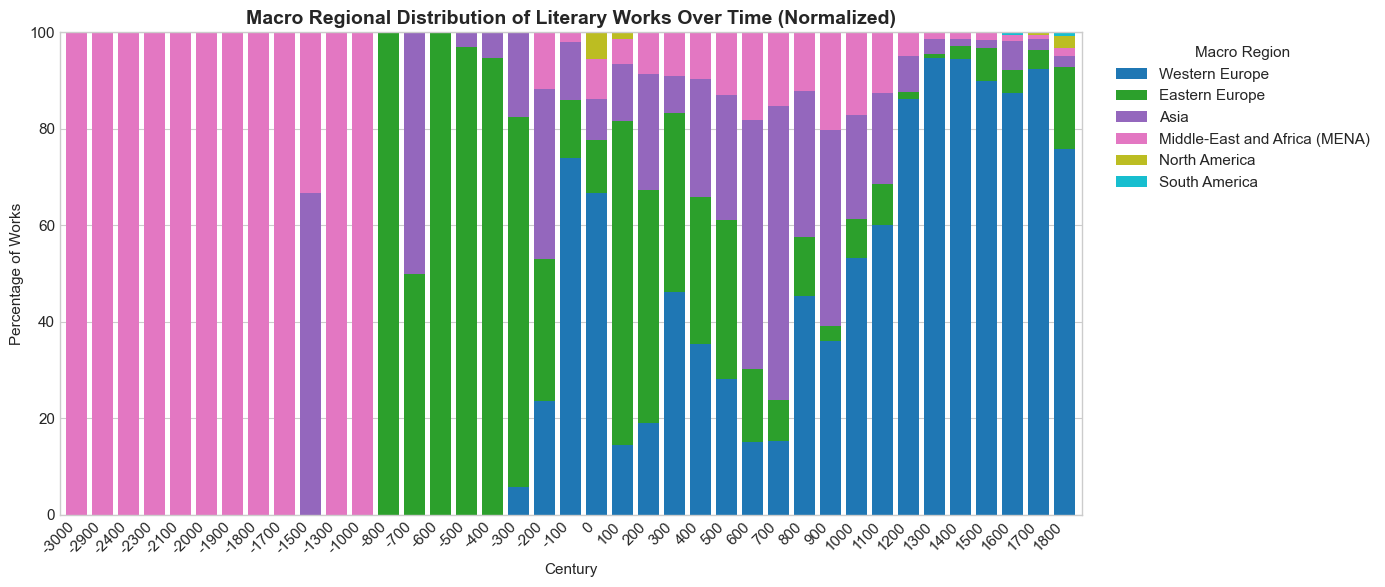

In [95]:
# Normalized stacked bar chart: Distribution per macro region over time (counting unique item_ids)
df['century'] = (df['year'] // 100) * 100
top_macro_regions = df.groupby('macro_region')['item_id'].nunique().sort_values(ascending=False).head(6).index.tolist()

timeline = df[df['macro_region'].isin(top_macro_regions)].groupby(['century', 'macro_region'])['item_id'].nunique().unstack(fill_value=0)
timeline = timeline[top_macro_regions]

# Normalize by century (each century = 100%)
timeline_norm = timeline.div(timeline.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(14, 6))
timeline_norm.plot(kind='bar', stacked=True, ax=ax, colormap='tab10', width=0.8)
ax.set_xlabel('Century')
ax.set_ylabel('Percentage of Works')
ax.set_title('Macro Regional Distribution of Literary Works Over Time (Normalized)', fontsize=14, fontweight='bold')
ax.legend(title='Macro Region', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.set_xticklabels([f'{int(x)}' for x in timeline_norm.index], rotation=45, ha='right')
ax.set_ylim(0, 100)
plt.tight_layout()
plt.show()

In [96]:
# Co-occurring Instance Types (excluding 'literary work')
# Find which work types tend to appear together on the same works
from itertools import combinations
from collections import Counter

conn = sqlite3.connect('../output/literary_works.db')

# Get all instance types per item (excluding 'literary work' as it's ubiquitous)
query_cooccur = """
SELECT DISTINCT lw.item_id, lw.instanceLabel
FROM literary_works lw
LEFT JOIN countries c ON lw.modern_country = c.modern_country
LEFT JOIN instances i ON lw.instanceLabel = i.label
WHERE lw.year IS NOT NULL 
  AND lw.year < 1900
  AND c.macro_region IS NOT NULL
  AND (i.excluded = 0 OR i.excluded IS NULL)
  AND lw.instanceLabel != 'literary work'
"""

df_cooccur = pd.read_sql(query_cooccur, conn)
conn.close()

# Group by item_id to get all instance types per work
items_instances = df_cooccur.groupby('item_id')['instanceLabel'].apply(set).reset_index()

# Filter to items with multiple instance types
multi_instance = items_instances[items_instances['instanceLabel'].apply(len) > 1]

# Count co-occurrences
cooccurrence = Counter()
for instances in multi_instance['instanceLabel']:
    for pair in combinations(sorted(instances), 2):
        cooccurrence[pair] += 1

# Create DataFrame of top co-occurring pairs
cooccur_df = pd.DataFrame([
    {'Instance Type 1': a, 'Instance Type 2': b, 'Co-occurrences': count}
    for (a, b), count in cooccurrence.most_common(25)
])
cooccur_df.index = range(1, len(cooccur_df) + 1)
cooccur_df.index.name = '#'

print(f"Items with multiple instance types (excl. 'literary work'): {len(multi_instance):,}")
print(f"\nTop 25 Co-occurring Instance Type Pairs:")
print(cooccur_df.to_string())

Items with multiple instance types (excl. 'literary work'): 3,979

Top 25 Co-occurring Instance Type Pairs:
             Instance Type 1                  Instance Type 2  Co-occurrences
#                                                                            
1               book edition                   penny dreadful             649
2                       book               serialized fiction             554
3                     lyrics                  translated song             372
4           translation work  version, edition or translation             256
5                    chapter               serialized fiction             207
6        lyrico-musical work         musical work/composition              92
7         serialized fiction                 translation work              80
8     collection of articles         series of creative works              69
9                   treatise                     written work              69
10            penny dreadful      

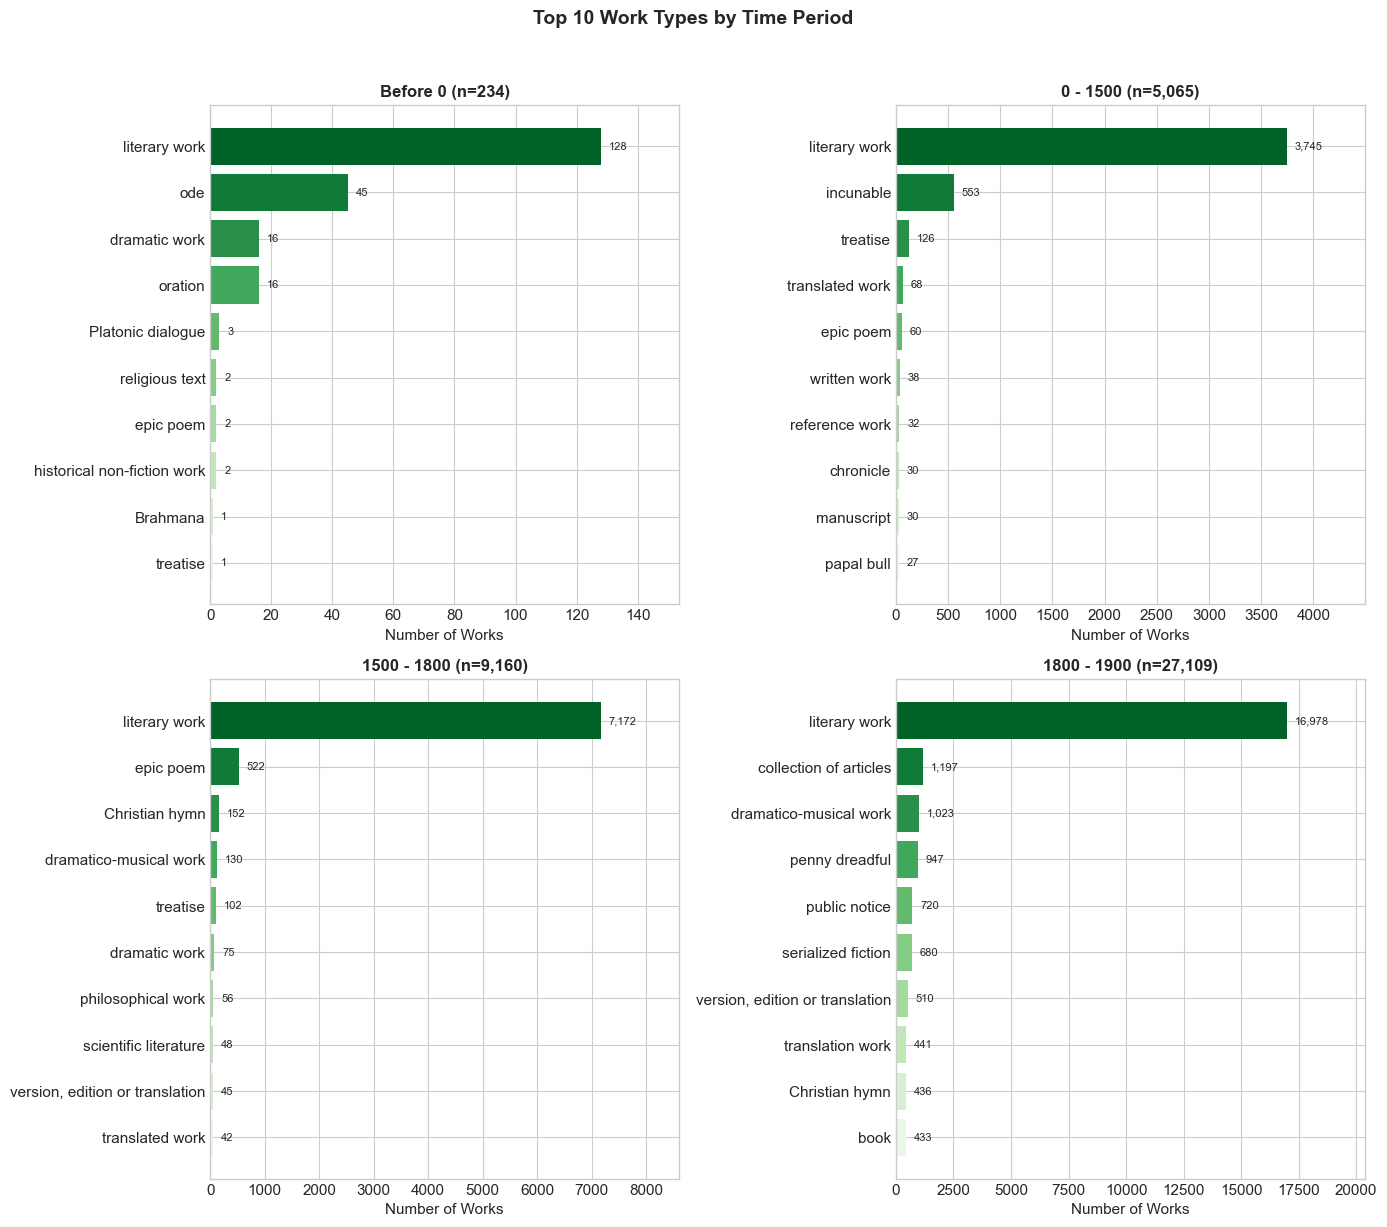

In [97]:
# Distribution of Work Types by Time Period
# Define time periods
periods = [
    ('Before 0', df['year'] < 0),
    ('0 - 1500', (df['year'] >= 0) & (df['year'] < 1500)),
    ('1500 - 1800', (df['year'] >= 1500) & (df['year'] < 1800)),
    ('1800 - 1900', (df['year'] >= 1800) & (df['year'] < 1900))
]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (period_name, mask) in enumerate(periods):
    ax = axes[idx]
    period_df = df[mask]
    
    # Get top 10 work types for this period
    instance_counts = period_df.groupby('instanceLabel')['item_id'].nunique().sort_values(ascending=False).head(10)
    
    colors = sns.color_palette('Greens_r', len(instance_counts))
    bars = ax.barh(instance_counts.index[::-1], instance_counts.values[::-1], color=colors[::-1])
    ax.set_xlabel('Number of Works')
    ax.set_title(f'{period_name} (n={period_df["item_id"].nunique():,})', fontsize=12, fontweight='bold')
    
    for bar, val in zip(bars, instance_counts.values[::-1]):
        ax.text(val + instance_counts.max()*0.02, bar.get_y() + bar.get_height()/2, 
                f'{val:,}', va='center', fontsize=8)
    ax.set_xlim(0, instance_counts.max() * 1.2)

plt.suptitle('Top 10 Work Types by Time Period', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [98]:
# Examples Section - Most famous work for each of the top 50 work types (by sitelinks)
conn = sqlite3.connect('../output/literary_works.db')

# Get data with sitelink_count and region
query_examples = """
SELECT DISTINCT
    lw.item_id,
    lw.itemLabel,
    lw.instanceLabel,
    lw.authorLabel,
    lw.sitelink_count,
    c.macro_region,
    c.region,
    MIN(lw.year) as year
FROM literary_works lw
LEFT JOIN countries c ON lw.modern_country = c.modern_country
LEFT JOIN instances i ON lw.instanceLabel = i.label
WHERE lw.year IS NOT NULL 
  AND lw.year < 1900
  AND c.macro_region IS NOT NULL
  AND (i.excluded = 0 OR i.excluded IS NULL)
GROUP BY lw.item_id, c.macro_region, c.region
"""

df_examples = pd.read_sql(query_examples, conn)

# Get English Wikipedia URLs
en_wiki = pd.read_sql("""
    SELECT item_id, sitelink as en_wikipedia 
    FROM sitelinks 
    WHERE sitelink LIKE '%en.wikipedia.org%'
""", conn)
conn.close()

# Merge with English Wikipedia URLs
df_examples = df_examples.merge(en_wiki, on='item_id', how='left')

def get_top_examples(data, top_n=50):
    """Get most famous work for each of the top N work types."""
    top_types = data.groupby('instanceLabel')['item_id'].nunique().sort_values(ascending=False).head(top_n).index.tolist()
    
    examples = []
    for instance_type in top_types:
        type_df = data[data['instanceLabel'] == instance_type]
        if len(type_df) > 0:
            most_famous = type_df.loc[type_df['sitelink_count'].idxmax()]
            # Use English Wikipedia if available, otherwise Wikidata
            if pd.notna(most_famous.get('en_wikipedia')):
                url = most_famous['en_wikipedia']
            else:
                url = f"https://www.wikidata.org/wiki/{most_famous['item_id']}"
            examples.append({
                'Work Type': instance_type,
                'Count': type_df['item_id'].nunique(),
                'Most Famous Work': most_famous['itemLabel'],
                'Author': most_famous['authorLabel'] if pd.notna(most_famous['authorLabel']) else '-',
                'Year': int(most_famous['year']) if pd.notna(most_famous['year']) else '-',
                'Sitelinks': int(most_famous['sitelink_count']) if pd.notna(most_famous['sitelink_count']) else 0,
                'Wikipedia': url
            })
    
    result = pd.DataFrame(examples)
    result.index = range(1, len(result) + 1)
    result.index.name = '#'
    return result

# Western Europe DataFrame
df_west = df_examples[df_examples['macro_region'] == 'Western Europe']
examples_west_df = get_top_examples(df_west, 50)

# Non-Western Europe DataFrame
df_non_west = df_examples[df_examples['macro_region'] != 'Western Europe']
examples_non_west_df = get_top_examples(df_non_west, 50)

In [99]:
# Western Europe - Top 50 Work Types with Most Famous Example
examples_west_df

,Work Type,Count,Most Famous Work,Author,Year,Sitelinks,Wikipedia
#,,,,,,,
1,literary work,21420,Don Quixote,Miguel de Cervantes,1605,146,https://en.wikipedia.org/wiki/Don_Quixote
2,collection of articles,1197,Le Brésil et la Société brésilienne,Adolphe d’Assier,1863,2,https://www.wikidata.org/wiki/Q17363084
3,dramatico-musical work,998,Carmen,Georges Bizet,1875,74,https://en.wikipedia.org/wiki/Carmen
4,penny dreadful,951,Varney the Vampire,James Malcolm Rymer,1845,11,https://en.wikipedia.org/wiki/Varney_the_Vampire
5,public notice,681,Q19135890,-,1891,1,https://www.wikidata.org/wiki/Q19135890
6,serialized fiction,680,The Time Machine,H. G. Wells,1895,57,https://en.wikipedia.org/wiki/The_Time_Machine
7,Christian hymn,592,How Great Thou Art,-,1885,20,https://en.wikipedia.org/wiki/How_Great_Thou_Art
8,epic poem,589,Pan Tadeusz,Adam Mickiewicz,1834,34,https://en.wikipedia.org/wiki/Pan_Tadeusz
9,incunable,583,36-line Bible,-,1500,6,https://en.wikipedia.org/wiki/36-line_Bible


In [100]:
# Non-Western Europe - Top 50 Work Types with Most Famous Example
examples_non_west_df

,Work Type,Count,Most Famous Work,Author,Year,Sitelinks,Wikipedia
#,,,,,,,
1,literary work,6638,Qur’an,-,631,280,https://en.wikipedia.org/wiki/Quran
2,"version, edition or translation",282,Three Character Classic,Stanislas Julien,1300,28,https://en.wikipedia.org/wiki/Three_Character_...
3,translation work,264,Oliwer Twist,Charles Dickens,1845,2,https://www.wikidata.org/wiki/Q32837053
4,dramatico-musical work,159,Eugene Onegin,-,1877,45,https://en.wikipedia.org/wiki/Eugene_Onegin_(o...
5,ode,46,Olympic Ode I,Pindar,-475,2,https://en.wikipedia.org/wiki/Olympian_1
6,public notice,39,Q126877452,-,1858,0,https://www.wikidata.org/wiki/Q126877452
7,periodical,39,Science,-,1880,62,https://en.wikipedia.org/wiki/Science_(journal)
8,dictionary,35,Dīwān ul-Lughat al-Turk,Mahmud al-Kashgari,1266,27,https://en.wikipedia.org/wiki/D%C4%ABw%C4%81n_...
9,religious text,33,Book of Mormon,Joseph Smith,1830,124,https://en.wikipedia.org/wiki/Book_of_Mormon


In [101]:
# =============================================================================
# WORKS CONTENT - Wikisource Availability by Time Period
# =============================================================================

conn = sqlite3.connect('../output/literary_works.db')

# Get all works with year and check for Wikisource links
query_wikisource = """
WITH works_with_year AS (
    SELECT 
        lw.item_id,
        MIN(lw.year) as year
    FROM literary_works lw
    LEFT JOIN countries c ON lw.modern_country = c.modern_country
    LEFT JOIN instances i ON lw.instanceLabel = i.label
    WHERE lw.year IS NOT NULL 
      AND lw.year < 1900
      AND c.macro_region IS NOT NULL
      AND (i.excluded = 0 OR i.excluded IS NULL)
    GROUP BY lw.item_id
),
wikisource_items AS (
    SELECT DISTINCT item_id
    FROM sitelinks
    WHERE sitelink LIKE '%wikisource%'
)
SELECT 
    w.item_id,
    w.year,
    CASE WHEN ws.item_id IS NOT NULL THEN 1 ELSE 0 END as has_wikisource
FROM works_with_year w
LEFT JOIN wikisource_items ws ON w.item_id = ws.item_id
"""

df_ws = pd.read_sql(query_wikisource, conn)
conn.close()

# Define time periods
def assign_period(year):
    if year < 0:
        return 'Before 0'
    elif year < 1500:
        return '0 - 1500'
    elif year < 1800:
        return '1500 - 1800'
    else:
        return '1800 - 1900'

df_ws['period'] = df_ws['year'].apply(assign_period)

# Calculate statistics per period
period_order = ['Before 0', '0 - 1500', '1500 - 1800', '1800 - 1900']
stats = []
for period in period_order:
    period_df = df_ws[df_ws['period'] == period]
    total = len(period_df)
    with_ws = period_df['has_wikisource'].sum()
    pct = (with_ws / total * 100) if total > 0 else 0
    stats.append({
        'Time Period': period,
        'Total Works': total,
        'With Wikisource': int(with_ws),
        'Percentage': f'{pct:.1f}%'
    })

# Add total row
total_works = len(df_ws)
total_ws = df_ws['has_wikisource'].sum()
total_pct = (total_ws / total_works * 100) if total_works > 0 else 0
stats.append({
    'Time Period': 'TOTAL',
    'Total Works': total_works,
    'With Wikisource': int(total_ws),
    'Percentage': f'{total_pct:.1f}%'
})

stats_df = pd.DataFrame(stats)
stats_df.index = [''] * len(stats_df)

print("=" * 60)
print("WORKS CONTENT - Wikisource Availability")
print("=" * 60)
print("\nLiterary works with Wikisource links (full text available):\n")
print(stats_df.to_string(index=False))
print("\n" + "=" * 60)

WORKS CONTENT - Wikisource Availability

Literary works with Wikisource links (full text available):

Time Period  Total Works  With Wikisource Percentage
   Before 0          234              104      44.4%
   0 - 1500         5065              638      12.6%
1500 - 1800         9160             2973      32.5%
1800 - 1900        27109            12627      46.6%
      TOTAL        41568            16342      39.3%



In [102]:
# =============================================================================
# EXPORT: Ancient & Medieval Works with Wikisource (Before 0 CE & 0-1500 CE)
# =============================================================================

conn = sqlite3.connect('../output/literary_works.db')

# Get works from before 1500 with their best Wikisource link (English preferred)
query_ancient_works = """
WITH works_before_1500 AS (
    SELECT DISTINCT
        lw.item_id,
        lw.itemLabel,
        lw.authorLabel,
        lw.instanceLabel,
        MIN(lw.year) as year,
        lw.sitelink_count,
        c.macro_region,
        c.region
    FROM literary_works lw
    LEFT JOIN countries c ON lw.modern_country = c.modern_country
    LEFT JOIN instances i ON lw.instanceLabel = i.label
    WHERE lw.year IS NOT NULL 
      AND lw.year < 1500
      AND c.macro_region IS NOT NULL
      AND (i.excluded = 0 OR i.excluded IS NULL)
    GROUP BY lw.item_id
),
wikisource_ranked AS (
    SELECT 
        item_id,
        sitelink as wikisource_url,
        ROW_NUMBER() OVER (
            PARTITION BY item_id 
            ORDER BY 
                CASE WHEN sitelink LIKE '%en.wikisource%' THEN 1 ELSE 2 END,
                sitelink
        ) as rn
    FROM sitelinks
    WHERE sitelink LIKE '%wikisource%'
)
SELECT 
    w.item_id,
    w.itemLabel as title,
    w.authorLabel as author,
    w.instanceLabel as work_type,
    w.year,
    w.sitelink_count,
    w.macro_region,
    w.region,
    ws.wikisource_url
FROM works_before_1500 w
INNER JOIN wikisource_ranked ws ON w.item_id = ws.item_id AND ws.rn = 1
ORDER BY w.year, w.sitelink_count DESC
"""

df_ancient_ws = pd.read_sql(query_ancient_works, conn)
conn.close()

# Add period column
df_ancient_ws['period'] = df_ancient_ws['year'].apply(
    lambda y: 'Before 0 CE' if y < 0 else '0 - 1500 CE'
)

# Add wikidata URL for reference
df_ancient_ws['wikidata_url'] = 'https://www.wikidata.org/wiki/' + df_ancient_ws['item_id']

# Reorder columns
df_ancient_ws = df_ancient_ws[[
    'item_id', 'title', 'author', 'work_type', 'year', 'period',
    'macro_region', 'region', 'sitelink_count', 'wikisource_url', 'wikidata_url'
]]

# Summary statistics
print("=" * 70)
print("ANCIENT & MEDIEVAL WORKS WITH WIKISOURCE (Before 1500 CE)")
print("=" * 70)
print(f"\nTotal works with Wikisource links: {len(df_ancient_ws):,}")
print(f"  - Before 0 CE:  {len(df_ancient_ws[df_ancient_ws['period'] == 'Before 0 CE']):,}")
print(f"  - 0 - 1500 CE:  {len(df_ancient_ws[df_ancient_ws['period'] == '0 - 1500 CE']):,}")
print(f"\nEnglish Wikisource: {df_ancient_ws['wikisource_url'].str.contains('en.wikisource').sum():,}")
print(f"Other languages:    {(~df_ancient_ws['wikisource_url'].str.contains('en.wikisource')).sum():,}")

# Save to CSV
output_path = '../data/ancient_medieval_works_wikisource.csv'
df_ancient_ws.to_csv(output_path, index=False)
print(f"\nSaved to: {output_path}")
print("=" * 70)

ANCIENT & MEDIEVAL WORKS WITH WIKISOURCE (Before 1500 CE)

Total works with Wikisource links: 742
  - Before 0 CE:  104
  - 0 - 1500 CE:  638

English Wikisource: 163
Other languages:    579

Saved to: ../data/ancient_medieval_works_wikisource.csv


In [103]:
df_ancient_ws

,item_id,title,author,work_type,year,period,macro_region,region,sitelink_count,wikisource_url,wikidata_url
0,Q8272,Epic of Gilgamesh,None,literary work,-2100,Before 0 CE,Middle-East and Africa (MENA),Arabic World,127,https://en.wikisource.org/wiki/Epic_of_Gilgamesh,https://www.wikidata.org/wiki/Q8272
1,Q727413,Rigveda,various authors,miscellany,-1499,Before 0 CE,Asia,Indian World,108,https://en.wikisource.org/wiki/The_Rigveda,https://www.wikidata.org/wiki/Q727413
2,Q8275,Iliad,Homer,literary work,-800,Before 0 CE,Eastern Europe,Balkans,176,https://en.wikisource.org/wiki/The_Iliad,https://www.wikidata.org/wiki/Q8275
3,Q667285,Works and Days,Hesiod,literary work,-800,Before 0 CE,Eastern Europe,Balkans,48,https://en.wikisource.org/wiki/Works_and_Days,https://www.wikidata.org/wiki/Q667285
4,Q156498,Theogony,Hesiod,literary work,-700,Before 0 CE,Eastern Europe,Balkans,69,https://en.wikisource.org/wiki/Theogony,https://www.wikidata.org/wiki/Q156498
...,...,...,...,...,...,...,...,...,...,...,...
737,Q3792988,The Triumph of Bacco and Arianna,Lorenzo de' Medici,literary work,1490,0 - 1500 CE,Western Europe,Italy,4,https://it.wikisource.org/wiki/Opera:Canzona_d...,https://www.wikidata.org/wiki/Q3792988
738,Q3827677,Laude,Jacopone da Todi,literary work,1490,0 - 1500 CE,Western Europe,Italy,3,https://it.wikisource.org/wiki/Opera:Laude_(Ja...,https://www.wikidata.org/wiki/Q3827677
739,Q25489503,Ha-Lichot Olam,Josua Levita,literary work,1490,0 - 1500 CE,Middle-East and Africa (MENA),Arabic World,2,https://he.wikisource.org/wiki/%D7%94%D7%9C%D7...,https://www.wikidata.org/wiki/Q25489503
740,Q19486611,Relación acerca de las antigüedades de los indios,Ramon Pané,literary work,1498,0 - 1500 CE,Western Europe,Spain,2,https://es.wikisource.org/wiki/Relaci%C3%B3n_a...,https://www.wikidata.org/wiki/Q19486611


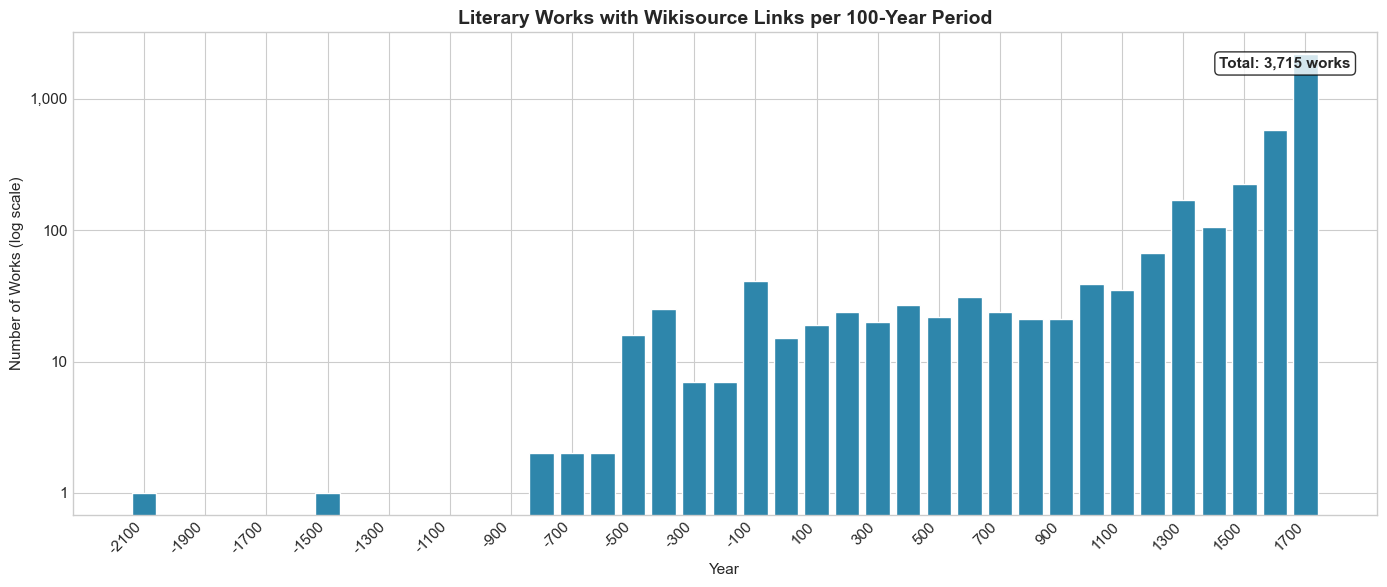

In [112]:
# =============================================================================
# Timeline: Works with Wikisource per 100-year period (log scale)
# =============================================================================

conn = sqlite3.connect('../output/literary_works.db')

query_ws_timeline = """
WITH works_with_year AS (
    SELECT 
        lw.item_id,
        MIN(lw.year) as year
    FROM literary_works lw
    LEFT JOIN countries c ON lw.modern_country = c.modern_country
    LEFT JOIN instances i ON lw.instanceLabel = i.label
    WHERE lw.year IS NOT NULL 
      AND lw.year < 1800
      AND c.macro_region IS NOT NULL
      AND (i.excluded = 0 OR i.excluded IS NULL)
    GROUP BY lw.item_id
),
wikisource_items AS (
    SELECT DISTINCT item_id
    FROM sitelinks
    WHERE sitelink LIKE '%wikisource%'
)
SELECT 
    w.item_id,
    w.year
FROM works_with_year w
INNER JOIN wikisource_items ws ON w.item_id = ws.item_id
"""

df_ws_timeline = pd.read_sql(query_ws_timeline, conn)
conn.close()

# Group by century
df_ws_timeline['century'] = (df_ws_timeline['year'] // 100) * 100
counts_ws_100y = df_ws_timeline.groupby('century')['item_id'].nunique()

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(counts_ws_100y.index, counts_ws_100y.values, width=80, color='#2E86AB', edgecolor='white')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Works (log scale)')
ax.set_title('Literary Works with Wikisource Links per 100-Year Period', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

min_year = (counts_ws_100y.index.min() // 100) * 100
max_year = (counts_ws_100y.index.max() // 100 + 1) * 100
ax.set_xticks(range(min_year, max_year + 1, 200))
ax.set_xticklabels([str(y) for y in range(min_year, max_year + 1, 200)], rotation=45, ha='right')

# Add total count annotation
total_ws = len(df_ws_timeline)
ax.text(0.98, 0.95, f'Total: {total_ws:,} works', transform=ax.transAxes, 
        ha='right', va='top', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [109]:
df_ws_timeline.item_id.nunique()

16342

In [107]:
df_ancient_ws.item_id.nunique()

742

In [113]:
# Preview the dataset - top works by sitelinks (most notable)
df_ancient_ws.sort_values('sitelink_count', ascending=False).head(20)

,item_id,title,author,work_type,year,period,macro_region,region,sitelink_count,wikisource_url,wikidata_url
242,Q428,Qur’an,None,literary work,631,0 - 1500 CE,Middle-East and Africa (MENA),Arabic World,280,https://en.wikisource.org/wiki/Qur%27an,https://www.wikidata.org/wiki/Q428
2,Q8275,Iliad,Homer,literary work,-800,Before 0 CE,Eastern Europe,Balkans,176,https://en.wikisource.org/wiki/The_Iliad,https://www.wikidata.org/wiki/Q8275
0,Q8272,Epic of Gilgamesh,None,literary work,-2100,Before 0 CE,Middle-East and Africa (MENA),Arabic World,127,https://en.wikisource.org/wiki/Epic_of_Gilgamesh,https://www.wikidata.org/wiki/Q8272
328,Q8279,Shahnameh,Abu-Mansur Daqiqi,literary work,1000,0 - 1500 CE,Middle-East and Africa (MENA),Persian World,126,https://en.wikisource.org/wiki/Shah_Nameh,https://www.wikidata.org/wiki/Q8279
71,Q60220,Aeneid,Virgil,literary work,-50,Before 0 CE,Western Europe,Italy,112,https://en.wikisource.org/wiki/Aeneid,https://www.wikidata.org/wiki/Q60220
347,Q8269,The Tale of Genji,Murasaki Shikibu,literary work,1010,0 - 1500 CE,Asia,Japan,111,https://en.wikisource.org/wiki/The_Tale_of_Genji,https://www.wikidata.org/wiki/Q8269
1,Q727413,Rigveda,various authors,miscellany,-1499,Before 0 CE,Asia,Indian World,108,https://en.wikisource.org/wiki/The_Rigveda,https://www.wikidata.org/wiki/Q727413
32,Q123397,The Republic,Plato,literary work,-379,Before 0 CE,Eastern Europe,Balkans,100,https://en.wikisource.org/wiki/The_Republic,https://www.wikidata.org/wiki/Q123397
104,Q184742,Metamorphoses,Ovid,literary work,1,0 - 1500 CE,Western Europe,Italy,75,https://en.wikisource.org/wiki/Metamorphoses,https://www.wikidata.org/wiki/Q184742
606,Q16438,The Decameron,Giovanni Boccaccio,literary work,1351,0 - 1500 CE,Western Europe,Italy,75,https://en.wikisource.org/wiki/The_Decameron,https://www.wikidata.org/wiki/Q16438
